#  CycleFlow - an example

In this notebook, we use CycleFlow to determine the cell cycle parameters of the TET21N cell line as it grows exponentially in culture. The data was generated by the authors of the package. Cf. manuscript for more details.

## Package imports
General imports

In [17]:
import pandas as pd
import numpy as np
import corner
import emcee
import multiprocessing
import functools

The following sets up the path to import cycleflow from the parent directory. This is unnecessary when CycleFlow is installed in your python environment

In [18]:
import sys; print(sys.version)
import os
from pathlib import Path
parent = Path(os.getcwd()).parent.as_posix()
sys.path.append(parent)

3.8.5 (default, Jul 21 2020, 10:42:08) 
[Clang 11.0.0 (clang-1100.0.33.17)]


Import CycleFlow

In [19]:
import cycleflow as cf

To use parallel MC sampling

In [20]:
Pool = multiprocessing.get_context('fork').Pool 

## Load data and initial parameters

In [21]:
read = functools.partial(pd.read_csv, skipinitialspace=True, index_col=0, header=0) # set some format options for convenience

#### Load EdU time course, mean and error

In [22]:
df = read('Tet21N.csv'); df

,mean_G1,mean_S,mean_G2,err_G1,err_S,err_G2
time_point,,,,,,
3,0.0371,0.2283,0.1827,0.0380,0.0410,0.0388
4,0.0343,0.2710,0.1727,0.0269,0.0284,0.0275
5,0.0223,0.2450,0.2264,0.0295,0.0311,0.0301
8,0.1558,0.2638,0.2230,0.0330,0.0347,0.0336
14,0.5222,0.1542,0.1842,0.0330,0.0347,0.0336
18,0.4130,0.2613,0.1128,0.0380,0.0401,0.0388


#### Steady state fractions in S and G2M

In [23]:
ss_df = read('Tetsteadystate.csv'); ss_df

,mean,error
phase,,
S,0.260,0.0124
G2,0.248,0.0188


#### Initial parameter values

In [24]:
initial_theta = read('InitThetaTet.csv', squeeze=True, header=None); initial_theta

0
lambda     1.25800
mu         2.90000
nu         0.87000
tau        2.66000
l         10.00000
alpha      0.00006
m_01       0.20000
m_02       0.10000
Name: 1, dtype: float64

#### Prior lower and upper bounds for parameters

In [25]:
prior_bounds = read('prior.csv'); prior_bounds

,min,max
lambda,0.01,6.00
mu,0.30,5.00
nu,0.50,10.00
tau,1.00,5.00
l,2.00,31.00
a,0.00,1.00
m_01,0.01,0.35
m_02,0.01,0.35


#### Massage data to match required input

In [26]:
mean, err = cf.convert_data(df, ss_df) # converts mean and errors in vectors to be used by CycleFlow
print(mean, err)
mean

[0.0371 0.0343 0.0223 0.1558 0.5222 0.413  0.2283 0.271  0.245  0.2638
 0.1542 0.2613 0.1827 0.1727 0.2264 0.223  0.1842 0.1128 0.26   0.248 ] [0.038  0.0269 0.0295 0.033  0.033  0.038  0.041  0.0284 0.0311 0.0347
 0.0347 0.0401 0.0388 0.0275 0.0301 0.0336 0.0336 0.0388 0.0124 0.0188]


array([0.0371, 0.0343, 0.0223, 0.1558, 0.5222, 0.413 , 0.2283, 0.271 ,
       0.245 , 0.2638, 0.1542, 0.2613, 0.1827, 0.1727, 0.2264, 0.223 ,
       0.1842, 0.1128, 0.26  , 0.248 ])

In [27]:
#time_points = df.index # time points for EdU labeling
time_points = [3,4,5,8,14,18]

In [28]:
theta = initial_theta.to_numpy() # retain only the values from the dataframe Thetas
print(theta)

[1.258e+00 2.900e+00 8.700e-01 2.660e+00 1.000e+01 6.000e-05 2.000e-01
 1.000e-01]


#### Construct the posterior distribution to be sampled

In [29]:
log_prior = cf.log_flat_prior(prior_bounds['min'], prior_bounds['max'])

In [30]:
log_likelihood = cf.log_likelihood(time_points, mean, err)

In [31]:
log_posterior = cf.log_posterior(log_likelihood, log_prior)

In [32]:
log_posterior(theta) # test

-380.6674944140367

#### Some initial parameter values to seed the MC runs and MC parameters

In [34]:
pos = theta + 1e-5*np.random.randn(50, 8) # initiate 50 walkers close to initial parameter set
nwalkers, ndim = pos.shape
chain_length = 15000

## Finally, run the emcee sampler

this should show a nice progress bar and take a while, depending on chain_length and your core count

In [35]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, pool=Pool())
sampler.run_mcmc(pos, chain_length, progress=True); # we set the chain length to 15000
#should be adjusted so that the autocorrelation time criterion below is met 

100%|██████████| 15000/15000 [21:47<00:00, 11.47it/s]


#### Test sampling quality
This calculates autocorrelation time for parameters, as per emcee's guideline, should be inferior to 1/50 of the MCMC chain for every parameters. The length of the chain should be set accordingly

In [36]:
tau = sampler.get_autocorr_time()
tau

array([249.72517902, 197.84211539, 253.31362421, 202.87449783,
       253.71210751, 219.88102675, 205.1824039 , 235.96249845])

#### First look at the Posterior Distribution
extracts the sample chain from the emcee output as a 2D array, saves the chain and then display the 5, 50 and 95th percentiles for each parameter


In [37]:
flat_samples = sampler.get_chain(discard = 1000, thin = 100, flat = True)
np.savetxt("CycleFlowExample.txt", flat_samples, delimiter=',')
print("5, 50, 95th percentiles.")
for (i, name) in enumerate(["lambda", "mu", "nu", "tau", "l", "a", "earlyS_frac", "lateS_frac"]):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    print(name, ":", mcmc)  

5, 50, 95th percentiles.

lambda : [1.68380452 3.61539418 4.98908109]
mu : [1.72815167 2.19505882 2.63009827]
nu : [2.66805422 2.93222241 3.32106985]
tau : [2.30750485 2.88429854 3.74306062]
l : [11.45097287 24.01329966 30.38260191]
a : [0.00174659 0.01784247 0.04942904]
earlyS_frac : [0.06765265 0.16131048 0.2536452 ]
lateS_frac : [0.07254596 0.12596846 0.24275867]


#### Get derived parameters
Generates sampled posterior distribution for the length of G1, S and G2M, kappa, and the steady states fractions in G1, S, G2M and G0

In [38]:
cycle = list(map(cf.get_cycle, flat_samples[0:10000,:]))
np.savetxt("CycleParameterExample.txt",np.asarray(cycle), delimiter=',')

#### Plot the posterior distributions for these parameters

In [39]:
labels = ["G1 length (h)", "S length (h)", "G2 length (h)", r"$\kappa$ (1/h)", "G1 fraction", "S fraction", "G2 fraction", "G0 fraction"]

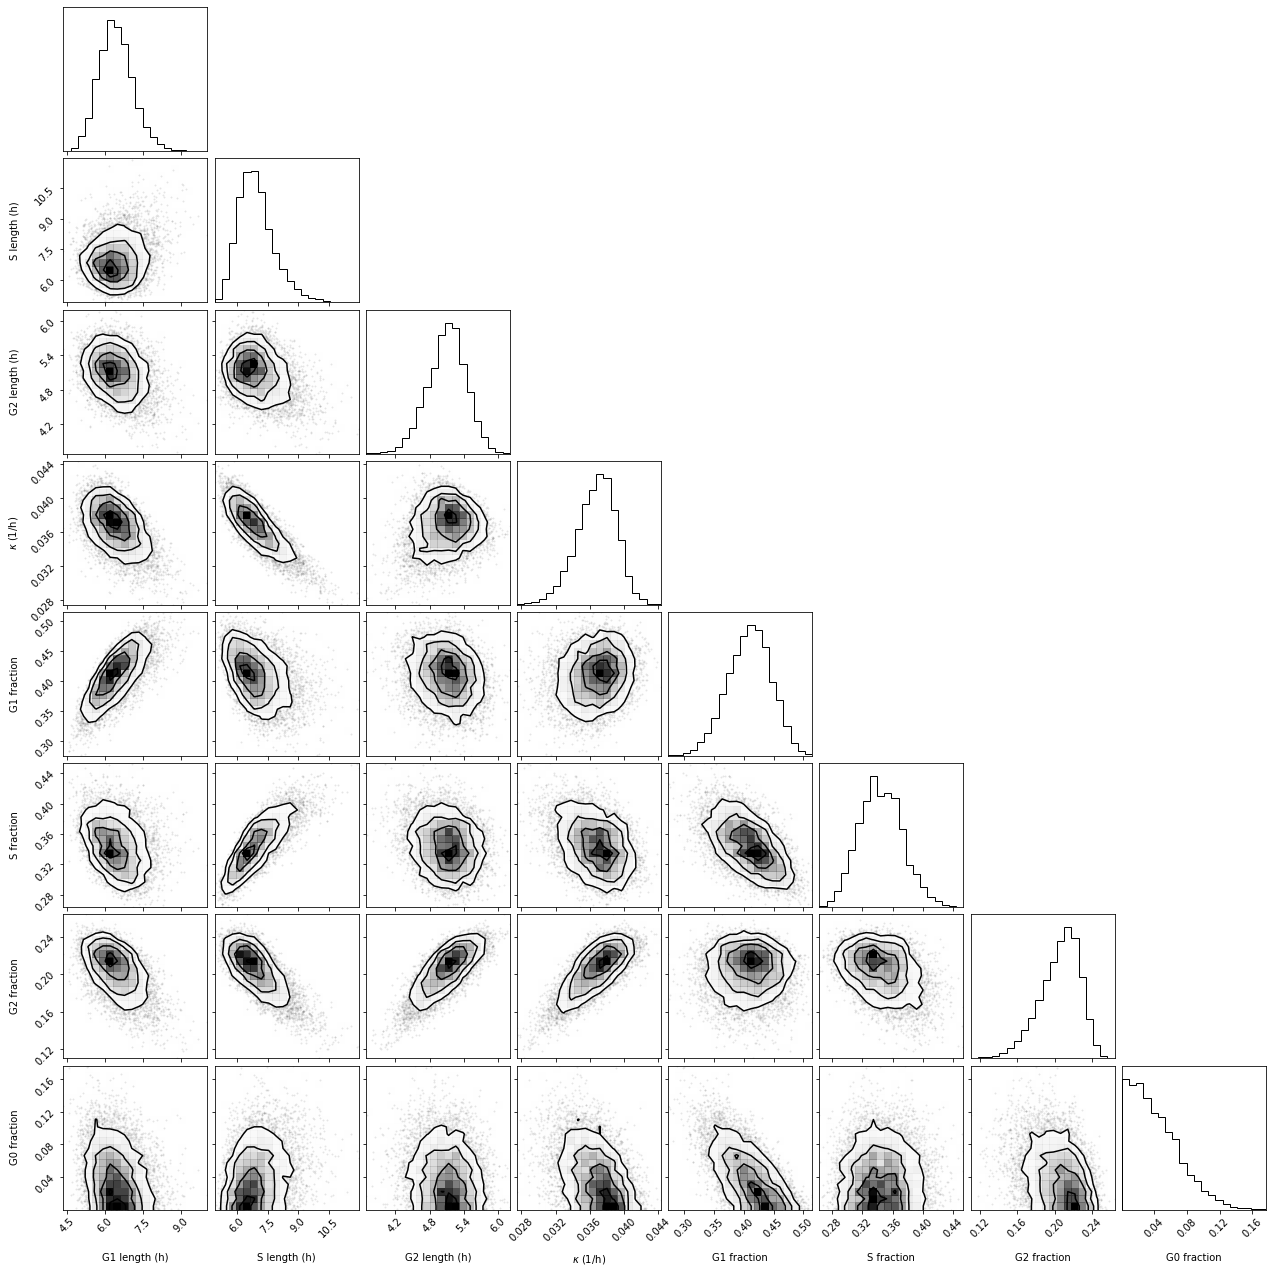

In [40]:
fig = corner.corner(cycle, labels=labels)